In [1]:
import sys
sys.path.append('../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc


In [4]:
wind_pred = pandas.read_csv('WindPred.csv')
demand_pred = pandas.read_csv('DemandPred.csv')
demand_pred = demand_pred.set_index('Unnamed: 0')
wind_pred = wind_pred.set_index('Unnamed: 0')

In [5]:
bigM = 10e6

In [10]:
scales = TemporalScale(discretization_list=[1, 24])


Wind = Resource(name='Wind', cons_max=bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW',
                 label='Power generated', demand=True, varying=[VaryingResource.DETERMINISTIC_DEMAND])

H2O = Resource(name='H2O', cons_max=bigM, basis='tons', label='Water')

Uranium = Resource(name='Uranium', cons_max=1000,
                   price=42.70/(250/2), basis='kg', label='Uranium')

LiI = Process(name='LiI', storage=Power, vopex=1302, capex=35164, fopex=0, prod_min=0,  prod_max=200,
              storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=bigM)

WF = Process(name='WF', conversion={Wind: -1/0.85, Power: 1}, vopex=990, capex=146200, fopex=0, prod_min=0,
             prod_max=70, label='Wind mill array', basis='MW', varying=[VaryingProcess.DETERMINISTIC_CAPACITY])

ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
               capex=7988951, fopex=0.04*0.730, vopex=7988, prod_min=0, prod_max=bigM, label='Small modular reactors (SMRs)', block='power_gen')

region = Location(name='region', processes={
    LiI, WF, ASMR}, capacity_factor={WF: wind_pred}, demand_factor={Power: demand_pred},  scales=scales, capacity_scale_level=1, demand_scale_level=1, label='some region wo dispatchable')

scenario = Scenario(name='example', demand={
                    region: {Power: 60}}, network=region, scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    scheduling_scale_level=1, label='example scenario')

In [12]:
milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND}, objective=Objective.COST, inventory_zero={region: {(LiI, Power): 10}})

results = solve(scenario=scenario, instance=milp_cost,
                solver='gurobi', saveformat='.pkl', name='det_1')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 565 rows, 467 columns and 1373 nonzeros
Model fingerprint: 0x04dec13d
Coefficient statistics:
  Matrix range     [4e-05, 8e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+07]
Presolve removed 517 rows and 347 columns
Presolve time: 0.00s
Presolved: 48 rows,

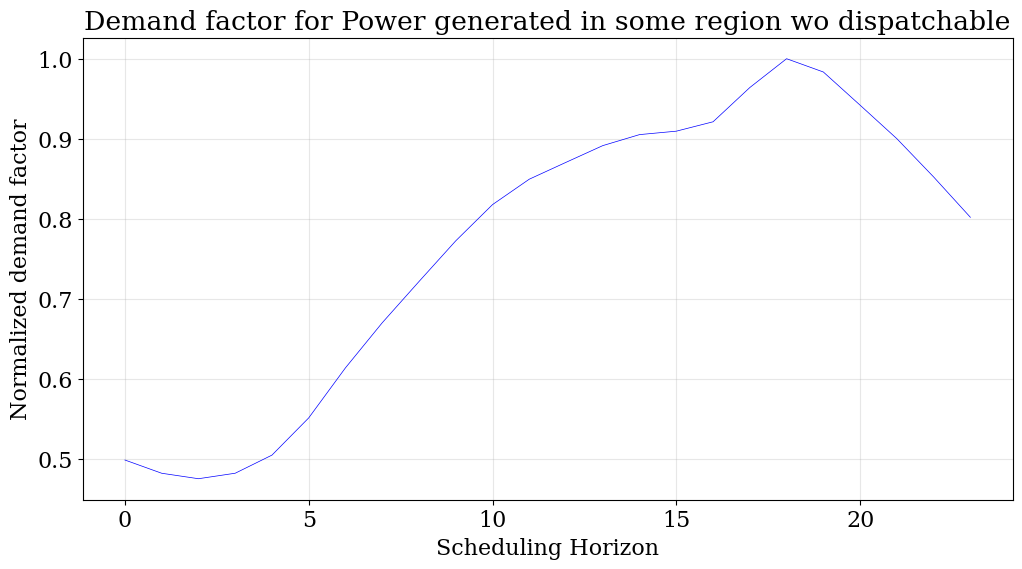

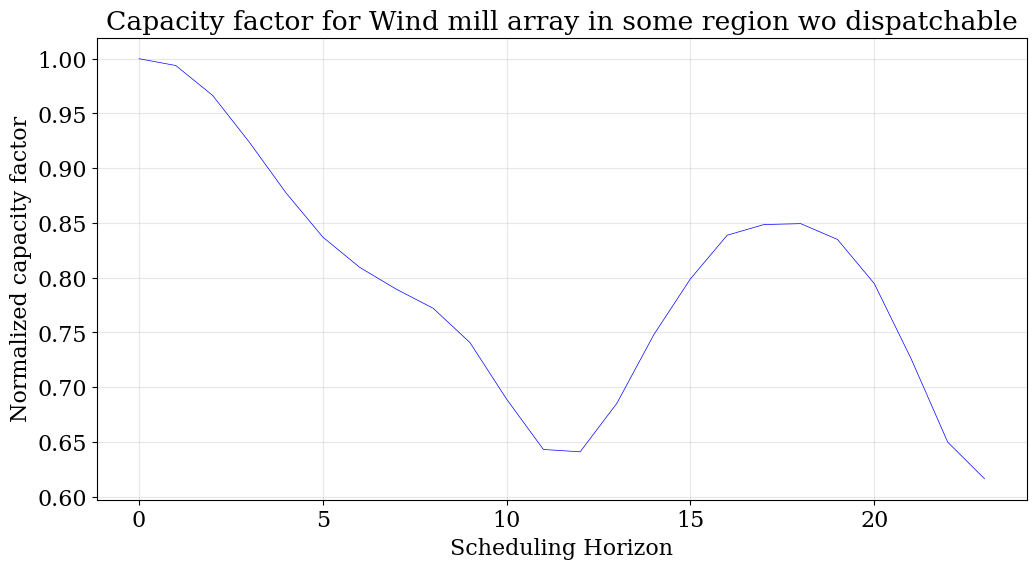

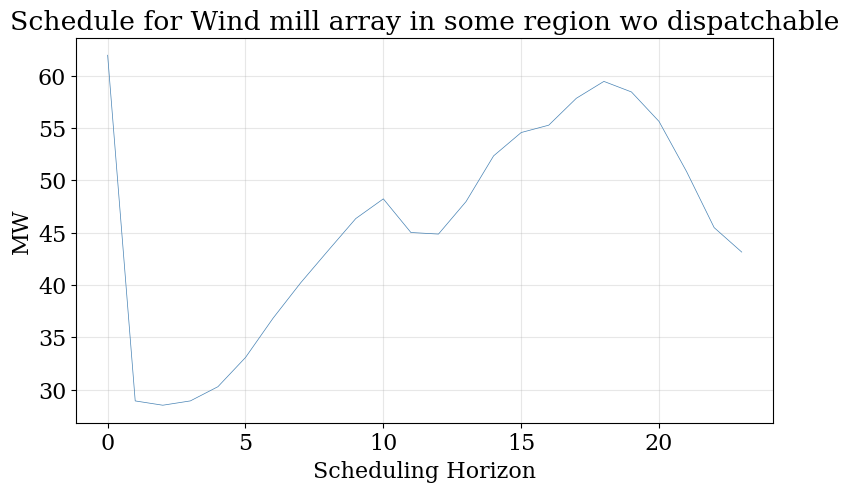

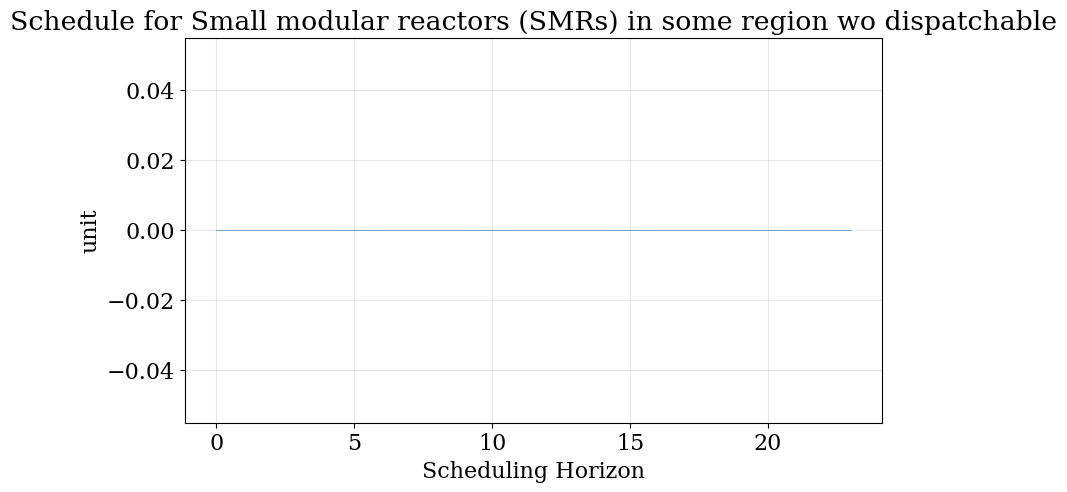

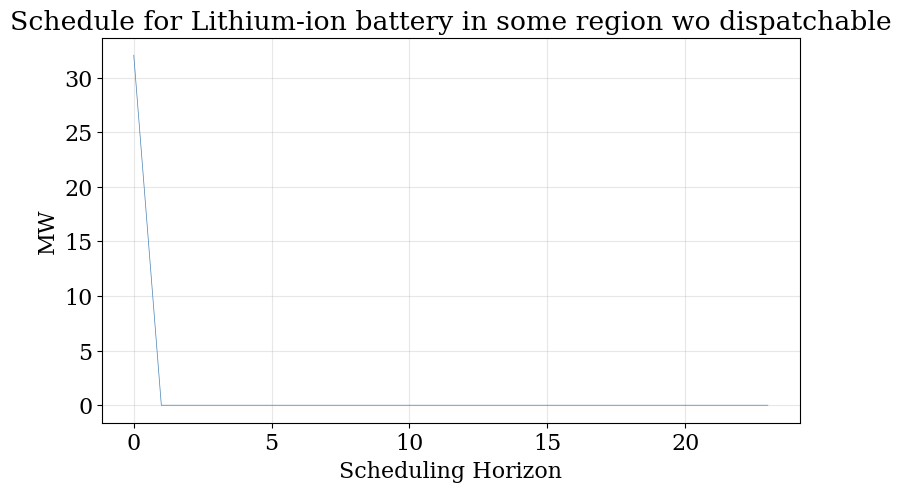

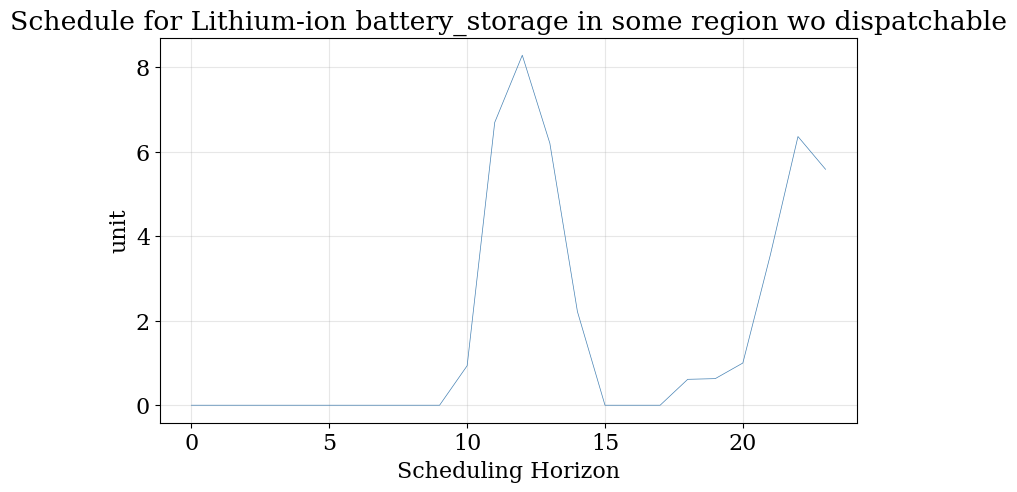

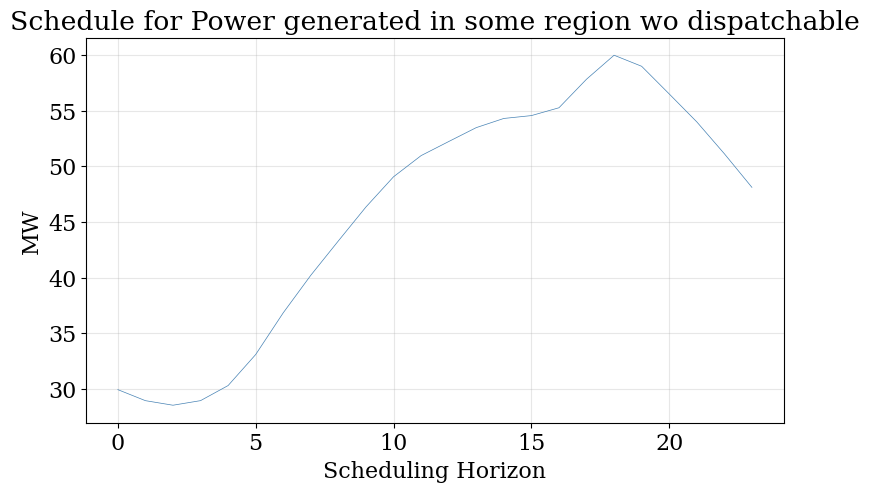

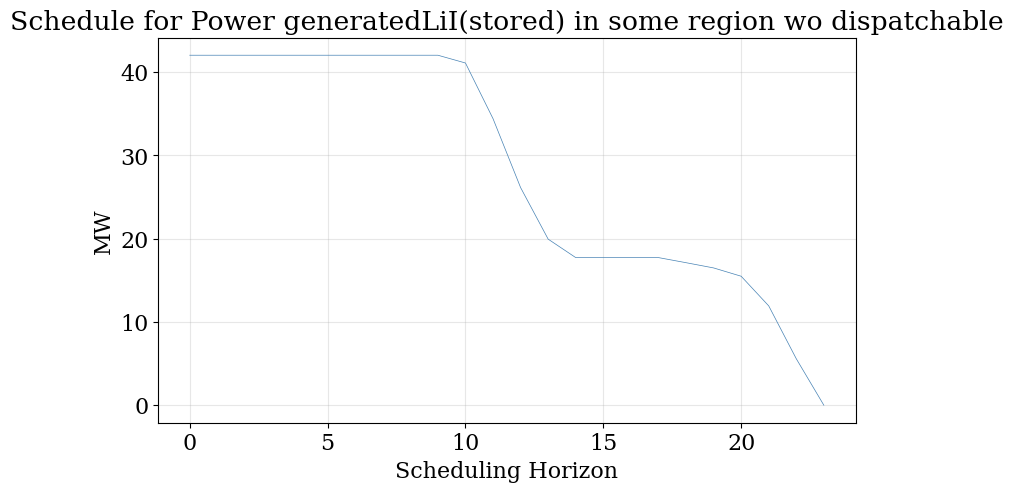

In [13]:
plot_scenario.demand_factor(scenario=scenario, location=region, resource=Power)
plot_scenario.capacity_factor(scenario=scenario, location=region, process=WF)

plot_results.schedule(results=results, y_axis='P', component='WF',
                      location='region', fig_size=(9, 5), color='steelblue')
plot_results.schedule(results=results, y_axis='P', component='ASMR',
                      location='region', fig_size=(9, 5), color='steelblue')
plot_results.schedule(results=results, y_axis='P', component='LiI',
                      location='region', fig_size=(9, 5), color='steelblue')
plot_results.schedule(results=results, y_axis='P', component='LiI_discharge',
                      location='region', fig_size=(9, 5), color='steelblue')
plot_results.schedule(results=results, y_axis='S', component='Power',
                      location='region', fig_size=(9, 5), color='steelblue')
plot_results.schedule(results=results, y_axis='Inv', component='LiI_Power_stored',
                      location='region', fig_size=(9, 5), color='steelblue')